In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from typing import Tuple, Union, List
from PIL import Image

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import DatasetFolder

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, auc
from sklearn.preprocessing import label_binarize

np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# Define the transformations
transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(degrees=15),
    # transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.Lambda(lambda x: x.to(torch.float32))
])

root = '../dataset'

# Initialize DatasetFolder for train and validation datasets
train_dataset = DatasetFolder(
    root=os.path.join(root, 'train'),
    loader=lambda x: torch.from_numpy(np.load(x)),
    extensions='npy',
    transform=transform
)
test_dataset = DatasetFolder(
    root=os.path.join(root, 'val'),
    loader=lambda x: torch.from_numpy(np.load(x)),
    extensions='npy',
    transform=transform
)

# Split the train dataset to get the validation dataset
train_dataset, val_dataset = random_split(train_dataset, [int(len(train_dataset) * 0.9), int(len(train_dataset) * 0.1)])

# Set the batch size
batch_size = 60

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print some information about the data
print(f'Train dataset size: {len(train_dataset)}')
print(f'Val dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')
print(f'Image shape: {train_dataset[0][0].shape}')
print(f'Classes: {train_dataset.dataset.classes}')
print(f'Image tensor type: {train_dataset[0][0].dtype}')
print(f'Batches: {len(train_loader)}')

Train dataset size: 27000
Val dataset size: 3000
Test dataset size: 7500
Image shape: torch.Size([1, 150, 150])
Classes: ['no', 'sphere', 'vort']
Image tensor type: torch.float32
Batches: 450


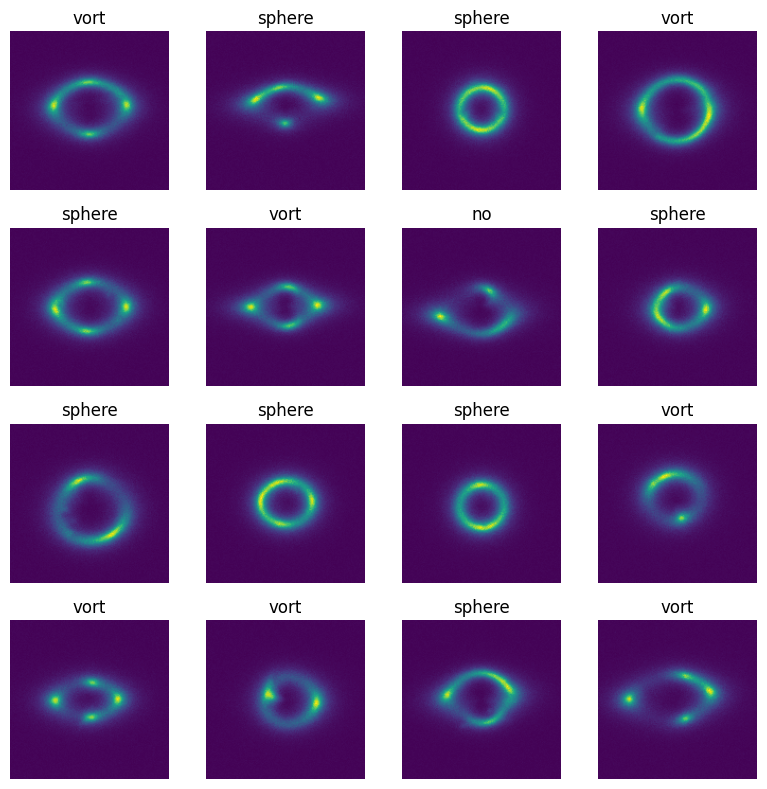

In [4]:
dataiter = iter(train_loader)
images, labels = dataiter.__next__()

# Visualize some images in the train dataset
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    if i < 16:
        image, label = images[i], labels[i]

        img = image.numpy().transpose((1, 2, 0))
        img = np.clip(img, 0, 1)

        ax.imshow(img)
        ax.set_title(train_dataset.dataset.classes[label])
        ax.axis('off')
    else:
        break

plt.tight_layout()
plt.show()

In [5]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=20, warmup_epochs=None, save_path='../best_param_ViT.pt'):
    history = {
        'epoch': [],
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    } # Initialize a dictionary to store epoch-wise results
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        # Warm-up period
        if warmup_epochs is not None:
            if epoch < warmup_epochs:
                lr = 1e-13 * (10 ** epoch) 
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr

        # Training phase
        model.train()
        train_loss = 0.0
        train_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(F.softmax(outputs, dim=1), 1)
            train_corrects += torch.sum(preds == labels.data).item()

        train_loss /= len(train_loader.dataset)
        train_acc = train_corrects / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data).item()

            val_loss /= len(val_loader.dataset)
            val_acc = val_corrects / len(val_loader.dataset)

        # Append epoch results to history
        history['epoch'].append(epoch)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Print results
        print(f"Epoch [{epoch + 1}/{num_epochs}] w/ LR = {optimizer.param_groups[0]['lr']}")
        print(f"\tTrain Loss: {train_loss:.4f}\tTrain Acc: {train_acc:.4f}")
        print(f"\tVal Loss: {val_loss:.4f}\tVal Acc: {val_acc:.4f}")

        # Step the scheduler
        if scheduler is not None:
            scheduler.step(val_loss)

        # Save the parameters with the best validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)

    model.load_state_dict(torch.load(save_path))

    return history, model

In [6]:
def evaluate_model(model, criterion, model_name):
    model.eval()
    y_pred_probs = []
    y_true = []
    total_loss = 0.0
    total_corrects = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            total_corrects += torch.sum(preds == labels).item()

            y_pred_probs.extend(outputs.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    test_loss = total_loss / len(test_loader.dataset)
    test_acc = total_corrects / len(test_loader.dataset)

    # Binarize the labels for ROC AUC
    y_true_binary = label_binarize(y_true, classes=[0, 1, 2])

    # Compute ROC AUC
    roc_auc = roc_auc_score(y_true_binary, y_pred_probs, multi_class='ovr')
    
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Accuracy: {test_acc:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    classes = ['no', 'sphere', 'vort']

    # Plot confusion matrix
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_true, np.argmax(y_pred_probs, axis=1))
    sns.heatmap(cm, annot=True, fmt='d', cmap='icefire', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Plot ROC curve for each class
    plt.subplot(1, 2, 2)
    fpr, tpr, _ = roc_curve(np.array(y_true_binary).ravel(), np.array(y_pred_probs).ravel())
    plt.plot(fpr, tpr, color='orange', label=f'{model_name}, {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

### **Lensformer**

In [12]:
class Flatten(nn.Module):
    """
    This module flattens the input tensor into a 2D tensor with a fixed
    number of neurons (elements) in the second dimension.

    Args:
        num_neurons_flatten (int): Number of neurons to flatten the input tensor to.

    Attributes:
        num_neurons_flatten (int): Number of neurons to flatten the input tensor to.

    Returns:
        Flattened tensor with shape `[batch_size, num_neurons_flatten]`.
    """

    def __init__(self, num_neurons_flatten: int):
        # Initialize the superclass
        super(Flatten, self).__init__()
        self.num_neurons_flatten = num_neurons_flatten

    def forward(self, x: Tensor) -> Tensor:
        # Flatten the tensor to the specified number of neurons
        return x.contiguous().view(-1, self.num_neurons_flatten)

In [13]:
class FeedForward(nn.Module):

  def __init__(self,
               in_features: int,
               out_features: int,
               activation_function: nn.Module,
               num_hidden_neurons: int,
               num_hidden_layers: int,
               task_type: str,
               dropout: float = 0.1,):
    """

    Initializes a FeedForward neural network.
    The FeedForward class is a neural network module in PyTorch that represents a multi-layer
    feedforward neural network. The class takes as input the number of input features, output
    features, activation function, number of hidden neurons, number of hidden layers, and
    dropout rate. It initializes a list of PyTorch modules that defines the layers of the neural
    network, with a linear layer, activation function, and dropout layer for the first layer,
    and a sequence of linear, activation, and dropout layers for the subsequent hidden layers.
    The final layer is a linear layer followed by an activation function choosen by the task_type
    argument (Identity function if task_type='regression', Sigmoid if task_type='binary_classification'
    or Softmax if task_type='multi_classification'). The forward method of the class takes an input
    tensor and applies each layer in the list of PyTorch modules in sequence to produce an output
    tensor, which represents the output of the feedforward neural network.

    Args:
      -in_features (int): number of input features.
      -out_features (int): number of output features.
      -activation_function (nn.Module): activation function to be used in hidden layers.
      -final_activation_function (nn.Module): activation function to be used in final layer (depends on the task).
      -num_hidden_neurons (int): number of neurons in each hidden layer.
      -num_hidden_layers (int): number of hidden layers in the network.
      -task_type (str): Task to be solved by the neural network. Must be one of: 'regression', 'binary_classification' or 'multi_classification'.
      -dropout (float, optional): dropout probability. Defaults to 0.1.

    Attributes:
      -feedforward (nn.ModuleList): List with each layer of the neural network.

    """

    super(FeedForward,self).__init__()
    self.feedforward = nn.ModuleList()

    # add input layer
    self.feedforward.append(nn.Linear(in_features,num_hidden_neurons))
    self.feedforward.append(activation_function())
    self.feedforward.append(nn.Dropout(dropout))

    # add hidden layers
    for _ in range(num_hidden_layers):
      self.feedforward.append(nn.Linear(num_hidden_neurons,num_hidden_neurons))
      self.feedforward.append(activation_function())
      self.feedforward.append(nn.Dropout(dropout))

    if task_type=='regression':

      self.final_activation_function = nn.Identity()

    elif task_type=='binary_classification':

      self.final_activation_function = nn.Sigmoid()

      if out_features != 1:
        raise ValueError("task_type='binary_classification' only supports 1 neuron on the end of the neural network (out_features = 1). If you want to use more than one neuron, use 'multi_classification' instead.")

    elif task_type=='multi_classification':

      self.final_activation_function = nn.Softmax(dim=1)

    else:
      raise ValueError("task_type must be either of 'regression','binary_classification' or 'multi_classification'.")

    # add output layer
    self.feedforward.append(nn.Linear(num_hidden_neurons,out_features))
    self.feedforward.append(self.final_activation_function)

  def forward(self,x: Tensor) -> Tensor:

    """

    Computes the forward pass of the feedforward neural network.
    Args:
       x (Tensor): input tensor of shape [batch_size, in_features]
    Returns:
       Tensor: output tensor of shape [batch_size, out_features]

    """

    for layer in self.feedforward:
      x = layer(x)
    return x

In [14]:
class ShiftedPatchTokenization(nn.Module):

    """

    This module performs shifted patch tokenization on input images,
    generating patches with positional encodings for use in transformer models.

    Attributes:
        embed_dim (int): The dimension of the output embedding.
        image_width (int): Width of the input image.
        image_height (int): Height of the input image.
        patch_width (int): Width of each patch.
        patch_height (int): Height of each patch.
        device (torch.device): The device to use for computation.
        num_patches (int): The total number of patches generated from an image.
        delta_x (int): The amount to shift along the x-axis.
        delta_y (int): The amount to shift along the y-axis.
        total_channels (int): The total number of channels in the output tensor.
        projection (nn.Conv2d): Conv2D layer for patch projection.
        layer_norm (nn.LayerNorm): Layer normalization.
        cls_token (nn.Parameter): Token for class.
        positional_encoding (nn.Parameter): Positional encoding for patches.

    """

    def __init__(self, image_size: Union[int,Tuple[int,int]],
                 patch_size: Union[int,Tuple[int,int]], embed_dim: int,
                 in_channels: int, device: torch.device):

        """
        Initializes the ShiftedPatchTokenization module.

        Args:
            image_size (Union[int, Tuple[int, int]]): Size of the input image. If an integer, it is assumed to be square-shaped.
            patch_size (Union[int, Tuple[int, int]]): Size of each patch. If an integer, it is assumed to be square-shaped.
            embed_dim (int): Dimension of the output embedding.
            in_channels (int): Number of channels in the input image.
            device (torch.device): Device to use for computation.

        Raises:
            ValueError: If the image dimensions are not divisible by the patch dimensions.
        """

        super(ShiftedPatchTokenization, self).__init__()

        # If image_size or patch_size is an integer, convert it to a tuple with equal width and height
        if type(image_size) == int:
            image_size = (image_size, image_size)
        if type(patch_size) == int:
            patch_size = (patch_size, patch_size)

        self.embed_dim = embed_dim
        self.image_width, self.image_height = image_size
        self.patch_width, self.patch_height = patch_size
        self.device = device

        # Check if the image dimensions are divisible by the patch dimensions
        if self.image_width % self.patch_width != 0 or self.image_height % self.patch_height != 0:
            raise ValueError("The image's width must be divisible by the patche's width and the image's height, by the patch's height")

        # Calculate the number of patches
        self.num_patches = int((self.image_width // self.patch_width) * (self.image_height // self.patch_height))

        # Set the translation amounts
        self.delta_x = self.patch_width // 2
        self.delta_y = self.patch_height // 2

        # Set the total number of channels for the output tensor
        self.num_transformations = 4
        self.total_channels = in_channels * (self.num_transformations + 1)

        # Define the projection layer
        self.projection = nn.Conv2d(in_channels=self.total_channels,
                                    out_channels=self.embed_dim,
                                    kernel_size=(self.patch_width, self.patch_height),
                                    stride=(self.patch_width, self.patch_height))

        # Define the layer normalization layer
        self.layer_norm = nn.LayerNorm(self.embed_dim)

        # Define the CLS token
        self.cls_token = nn.Parameter(torch.zeros((1, 1, self.embed_dim)))

        # Define the positional encoding
        self.positional_encoding = nn.Parameter(torch.zeros((1, 1 + self.num_patches, self.embed_dim)))

    def translate_image(self, image: Tensor, delta_x: int, delta_y: int, device: torch.device):

        """
        Translates an image by specified amounts along the x and y axes.

        Args:
            image (Tensor): Input image tensor.
            delta_x (int): Shift amount along the x-axis.
            delta_y (int): Shift amount along the y-axis.
            device (torch.device): Device to use for computation.

        Returns:
            Tensor: Translated image.
        """

        translated_image = transforms.functional.affine(image, angle=0, translate=(delta_x, delta_y), fill=0, scale=1, shear=0)
        translated_image = translated_image.to(device)
        return translated_image

    def get_num_patches(self):

        """
        Gets the total number of patches that would be created from an image.

        Returns:
            int: The total number of patches.
        """

        return self.num_patches

    def forward(self, image: Tensor) -> Tensor:

        """
        Performs the forward pass, tokenizing the image into patches and adding positional encodings.

        Args:
            image (Tensor): A tensor representing an image, of shape (batch_size, in_channels, image_height, image_width).

        Returns:
            Tensor: A tensor of tokenized image patches, of shape (batch_size, num_patches+1, embed_dim).
        """

        batch_size = image.size(0)


        # generate shifted versions of the image
        shift_left_up = self.translate_image(image, -self.delta_x, -self.delta_y,self.device)
        shift_right_up = self.translate_image(image, self.delta_x, -self.delta_y,self.device)
        shift_left_down = self.translate_image(image, -self.delta_x, self.delta_y,self.device)
        shift_right_down = self.translate_image(image, self.delta_x, self.delta_y,self.device)

        # concatenate the original image with its shifted versions
        concatenated_images = torch.cat((image, shift_left_up, shift_right_up, shift_left_down, shift_right_down), dim=1)

        # project the concatenated image onto a lower-dimensional embedding
        projected_patches = self.projection(concatenated_images)
        patches = projected_patches.flatten(2)
        patches = patches.transpose(1, 2)

        patches.to(self.device)

        # apply layer normalization to the patches
        patches = self.layer_norm(patches)

        # append a learnable "class token" to the beginning of the patch sequence
        cls = self.cls_token.expand(batch_size, -1, -1)
        patches = torch.cat((cls, patches), dim=1)

        patches.to(self.device)

        # add learnable positional encodings to the patches
        patches = patches + self.positional_encoding

        return patches

In [15]:
class MultiLocallySelfAttention(nn.Module):

    """
    Implements a MultiLocallySelfAttention layer, which is a specialized form of multi-head self-attention
    designed to attend over local patches of an image.

    Attributes:
        embed_dim (int): Embedding dimensionality of the input.
        num_heads (int): Number of attention heads.
        num_patches (int): Number of patches in the image.
        dropout (float): Dropout rate for regularization.
        device (torch.device): Device to run the computations on.
        attn_mask (torch.Tensor): Attention mask for self-attention operation.
        mha (nn.MultiheadAttention): Standard multi-head attention layer.
    """

    def __init__(self, embed_dim: int, num_heads: int, num_patches: int, device: torch.device, dropout: float = 0.1):

        """
        Initializes the MultiLocallySelfAttention layer.

        Args:
            embed_dim (int): Dimensionality of the input embeddings.
            num_heads (int): Number of attention heads.
            num_patches (int): Number of patches in the image.
            device (torch.device): Device to run the computations on.
            dropout (float): Dropout rate for regularization. Default is 0.1.

        """

        super().__init__()

        # Store layer parameters
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.num_patches = num_patches
        self.dropout = dropout
        self.device = device

        # Initialize attention mask (a lower triangular matrix with True values)
        self.attn_mask = torch.eye(1 + self.num_patches, 1 + self.num_patches, dtype=torch.bool, requires_grad=False)
        self.attn_mask = self.attn_mask.to(device)

        # Initialize multi-head attention layer
        self.mha = nn.MultiheadAttention(embed_dim, num_heads, dropout, batch_first=True)

    def forward(self, key: Tensor, query: Tensor, value: Tensor) -> Tensor:

        """
        Performs the forward pass through the MultiLocallySelfAttention layer.

        Args:
            key (Tensor): The key tensor for attention mechanism.
            query (Tensor): The query tensor for attention mechanism.
            value (Tensor): The value tensor for attention mechanism.

        Returns:
            Tensor: The output tensor after applying multi-head attention.

        """

        # Apply multi-head attention
        x, _ = self.mha(query, key, value, attn_mask=self.attn_mask)

        return x

In [16]:
class TransformerLSABlock(nn.Module):

    """
    Implements a TransformerLSABlock, a building block for transformer models designed
    to work on image patches. This block contains multi-locally self-attention,
    feedforward network, and layer normalization components.

    Attributes:
        mlsa (MultiLocallySelfAttention): MultiLocallySelfAttention layer.
        first_norm (nn.LayerNorm): First layer normalization.
        feedforward (FeedForward): FeedForward neural network layer.
        second_norm (nn.LayerNorm): Second layer normalization.
        dropout_layer (nn.Dropout): Dropout layer for regularization.
        device (torch.device): Device to run the computations on.
        temperature (nn.Parameter): Temperature parameter for attention mechanism.
    """

    def __init__(self,
                 embed_dim: int,
                 num_heads: int,
                 num_patches: int,
                 num_hidden_neurons: int,
                 activation_function: nn.Module,
                 device: torch.device,
                 dropout: float = 0.1):
        """
        Initializes the TransformerLSABlock layer.

        Args:
            embed_dim (int): The dimensionality of the input embeddings.
            num_heads (int): Number of attention heads.
            num_patches (int): Number of patches in the image.
            num_hidden_neurons (int): Number of neurons in the hidden layer of the feedforward network.
            activation_function (nn.Module): Activation function used in the feedforward network.
            device (torch.device): Device to run the computations on.
            dropout (float, optional): Dropout rate for regularization. Default is 0.1.
        """

        super().__init__()

        # initialize the multi-locally self-attention layer
        self.mlsa = MultiLocallySelfAttention(embed_dim, num_heads, num_patches, device, dropout)

        # initialize the first layer normalization
        self.first_norm = nn.LayerNorm(embed_dim)

        # initialize the feedforward network
        self.feedforward = FeedForward(embed_dim, embed_dim, activation_function, num_hidden_neurons, num_hidden_layers=1,
                                       task_type='regression', dropout=dropout)

        # initialize the second layer normalization
        self.second_norm = nn.LayerNorm(embed_dim)

        # initialize the dropout layer
        self.dropout_layer = nn.Dropout(dropout)

        # the device to store the tensors on
        self.device = device

        # initialize temperature parameter (a scalar used to divide the queries)
        self.temperature = nn.Parameter(torch.ones(1))

    def forward(self, key: torch.Tensor, query: Union[torch.Tensor, None] = None, value: Union[torch.Tensor, None] = None) -> torch.Tensor:
        """
        Performs the forward pass through the TransformerLSABlock layer.

        Args:
            key (Tensor): The key tensor for the attention mechanism.
            query (Union[Tensor, None], optional): The query tensor for the attention mechanism.
                                                  If None, it defaults to the key tensor divided by temperature.
                                                  Default is None.
            value (Union[Tensor, None], optional): The value tensor for the attention mechanism.
                                                   If None, it defaults to the key tensor.
                                                   Default is None.

        Returns:
            Tensor: The output tensor after applying multi-locally self-attention,
                    layer normalization, feedforward network, and dropout.
        """
        # Prepare key, query, and value tensors
        key = key.to(self.device)
        if query is None:
            query = (key / self.temperature).to(self.device)
        if value is None:
            value = key.to(self.device)

        # apply multi-locally self-attention
        value = value + self.mlsa(key, query, value)

        # apply first layer normalization
        value = self.first_norm(value)

        # apply feedforward network
        value = value + self.feedforward(value)

        # apply second layer normalization
        value = self.second_norm(value)

        # apply dropout
        value = self.dropout_layer(value)

        return value

In [17]:

class RelativisticPhysicalInformedEncoder(nn.Module):
    """
    A PyTorch module to perform inverse gravitational lensing using the Singular Isothermal Sphere (SIS) model.

    Attributes:
        pixel_scale (float): The scale of each pixel in the image, often in arcseconds per pixel.
        profile_size (int): The size of the image profile.
        half_profile_size (int): Half of the profile size.
        num_patches (int): Number of patches.
        embed_dim (int): Dimension of the embedding.
        num_heads (int): Number of heads in the transformer.
        num_hidden_neurons (int): Number of hidden neurons.
        eps (float): Float number used to avoid division by zero.
        transformer_activation_function (nn.Module): Activation function used in the transformer.
        num_transformer_blocks (int): Number of transformer blocks.
        device (torch.device): Device to which tensors will be moved.
        transformer (nn.ModuleList): List of transformer blocks.
        num_neurons_flatten (int): Number of neurons in the Flatten layer.
        grid_x (Tensor): Grid of x coordinates.
        grid_y (Tensor): Grid of y coordinates.
        flat_grid_x (Tensor): Flattened grid of x coordinates.
        flat_grid_y (Tensor): Flattened grid of y coordinates.
    """
    def __init__( self,
                  image_size: int,
                  patch_size: int ,
                  embed_dim: int,
                  num_patches: int,
                  num_heads: int,
                  num_hidden_neurons: int,
                  transformer_activation_function: nn.Module,
                  num_transformer_blocks: int,
                  device: torch.device,
                  dropout: float = 0.1,
                  pixel_scale:float =0.101,
                  k_min: float = 0.8,
                  k_max: float = 1.2,
                  eps: float = 1e-8
                  ):


        """
        Initialize the module.

        Args:
            image_size (int): The size of the image.
            patch_size (int): The size of each patch.
            embed_dim (int): The embedding dimension.
            num_patches (int): The number of patches.
            num_heads (int): The number of heads in the transformer.
            num_hidden_neurons (int): The number of hidden neurons.
            transformer_activation_function (nn.Module): The activation function used in the transformer.
            num_transformer_blocks (int): The number of transformer blocks.
            device (torch.device): The device to which tensors will be moved.
            dropout (float, optional): The dropout rate. Defaults to 0.1.
            pixel_scale (float, optional): The scale of each pixel in the image, often in arcseconds per pixel. Defaults to 0.101.
            k_min (float, optional): Minimum value of the potential correction parameter.  Defaults to 0.8.
            k_max (float, optional): Maximum value of the potencial correction parameter.  Defaults to 1.2.
            eps (float): Float number used to avoid division by zero. Defaluts to 1e-8.
        """

        super(RelativisticPhysicalInformedEncoder, self).__init__()

        # Initialize variables
        self.pixel_scale = pixel_scale
        self.profile_size = image_size
        self.half_profile_size = self.profile_size // 2
        self.num_patches = num_patches
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.num_hidden_neurons = num_hidden_neurons
        self.transformer_activation_function = transformer_activation_function
        self.num_transformer_blocks = num_transformer_blocks
        self.device = device
        self.k_min = k_min
        self.k_max = k_max
        self.eps = eps

        # Create an empty list for the transformer blocks
        self.transformer = nn.ModuleList()

        # Calculate the number of neurons for the Flatten layer
        self.num_neurons_flatten = (self.num_patches+1)*embed_dim

        # Create an empty list for the transformer blocks
        self.transformer = nn.ModuleList()

        # Create a for loop that iterates over the number of transformer blocks

        for _ in range(num_transformer_blocks):
          # Add a TransformerLSABlock to the transformer list
          self.transformer.append(

              TransformerLSABlock(embed_dim,
                                  num_heads,
                                  self.num_patches,
                                  num_hidden_neurons,
                                  transformer_activation_function,
                                  device,
                                  dropout)
          )

        # Create a compressor (FeedFoward) compress the size of num_neurons_flatten
        self.transformer.append(nn.Flatten())
        self.transformer.append(nn.Linear(self.num_neurons_flatten,self.profile_size*self.profile_size))
        self.transformer.append(nn.Sigmoid())

        # Create a grid for image coordinates
        x_coordinates = torch.linspace(-self.half_profile_size, self.half_profile_size-1, self.profile_size) * self.pixel_scale
        y_coordinates = torch.linspace(-self.half_profile_size, self.half_profile_size-1, self.profile_size) * self.pixel_scale
        self.grid_x, self.grid_y = torch.meshgrid(x_coordinates, y_coordinates)
        self.flat_grid_x = self.grid_x.flatten().to(self.device)
        self.flat_grid_y = self.grid_y.flatten().to(self.device)


    def forward(self, input_images: Tensor, patches: Tensor)->Tensor:

        """
        Forward pass through the module.

        Args:
            input_images (torch.Tensor): The input images.
            patches (torch.Tensor): The patches extracted from the images.

        Returns:
            output_images (torch.Tensor): The output images after inverse gravitational lensing.
        """

        # Get the batch size from the input images
        batch_size = input_images.shape[0]

        # Generate k using the sequential model
        for i, layer in enumerate(self.transformer):
            if i == 0:
                k_sigmoid = layer(patches)
            else:
                k_sigmoid = layer(k_sigmoid)

        # Reshape k_sigmoid to have shape [batch_size, profile_size, profile_size]
        k_sigmoid = k_sigmoid.view(-1, self.profile_size, self.profile_size)

        # Flatten k_sigmoid to match the shape of non_zero_x and non_zero_radius
        k_sigmoid_flat = k_sigmoid.view(-1, self.profile_size*self.profile_size)

        # Bias and Scalling
        k_sigmoid_flat = self.k_min + (self.k_max-self.k_min)*k_sigmoid_flat

         # Flatten the input images for easier indexing
        flat_input_images = input_images.view(batch_size, -1)

        # Create a mask for non-zero coordinates in the grid
        non_zero_mask = (self.flat_grid_x != 0) | (self.flat_grid_y != 0)

        # Select only the non-zero indices to match with non_zero_x and non_zero_radius
        k_sigmoid_non_zero = k_sigmoid_flat[:, non_zero_mask]

        # Get the shape of k_sigmoid_non_zero
        shape_k_sigmoid_non_zero = k_sigmoid_non_zero.shape

        # Reshape k to have a batch dimension compatible for broadcasting
        k = k_sigmoid_non_zero.view(shape_k_sigmoid_non_zero[0], 1, 1, shape_k_sigmoid_non_zero[1])

        # Apply the mask to get non-zero coordinates
        non_zero_x = self.flat_grid_x[non_zero_mask]
        non_zero_y = self.flat_grid_y[non_zero_mask]

        # Calculate the radius for non-zero coordinates
        non_zero_radius = torch.sqrt(non_zero_x ** 2 + non_zero_y ** 2)

        # Expand dimensions for broadcasting
        non_zero_radius = non_zero_radius[None, None, None, :]

        # Compute shifted coordinates based on the Gravitational Lens Equation to SIS model
        shifted_x = (non_zero_x[None, None, None, :] - k * non_zero_x[None, None, None, :] / non_zero_radius)
        shifted_y = (non_zero_y[None, None, None, :] - k * non_zero_y[None, None, None, :] / non_zero_radius)

        # Convert shifted coordinates to indices in the image grid
        shifted_x_idx = torch.round(shifted_x / self.pixel_scale + self.half_profile_size).long()
        shifted_y_idx = torch.round(shifted_y / self.pixel_scale + self.half_profile_size).long()

        # Initialize the output image tensor and flatten it
        output_images = torch.zeros(batch_size, self.profile_size, self.profile_size).to(self.device)
        flat_output_images = output_images.view(batch_size, -1)

        # Calculate 1D indices from shifted_x_idx and shifted_y_idx
        one_d_indices = shifted_x_idx * self.profile_size + shifted_y_idx

        # Flatten the input images for easier indexing
        flat_input_images = input_images.view(batch_size, -1)

        # Get the current values at the shifted positions in the flat output images
        output_values_at_shifted_positions = flat_output_images.gather(1, one_d_indices.view(batch_size, -1))

        # Get the corresponding values from the original positions in the flat input images
        input_values_at_original_positions = flat_input_images[:, non_zero_mask]

        # Update the output image based on the algorithm
        updated_values = torch.where(output_values_at_shifted_positions == 0,
                                    input_values_at_original_positions,
                                    (output_values_at_shifted_positions + input_values_at_original_positions) / 2)

        # Assign the updated values back to the flat output images
        flat_output_images.scatter_(1, one_d_indices.view(batch_size, -1), updated_values)

        # Reshape the flat output images back to their original shape
        output_images = flat_output_images.view(batch_size, self.profile_size, self.profile_size)


        # Normalize the output images
        max_values, _ = output_images.max(dim=1, keepdim=True)
        max_values, _ = max_values.max(dim=2, keepdim=True)
        output_images = output_images / (max_values + self.eps)

        return output_images


In [18]:
class Lensformer(nn.Module):
    def __init__(self,
                 image_size: int,
                 patch_size: int,
                 embed_dim: int,
                 in_channels: int,
                 num_classes: int,
                 num_heads: int,
                 num_hidden_neurons: int,
                 num_hidden_layers: int,
                 transformer_activation: nn.Module,
                 feedforward_activation: nn.Module,
                 num_transformer_blocks: int,
                 device: torch.device,
                 dropout_rate: float = 0.1):
        """
        Initializes Lensiformer, a Relativistic Physics-Informed Vision Transformer (PIViT) Architecture for Dark Matter Morphology.

        Args:
            image_size (int): Size of the input image (assumed square).
            patch_size (int): Size of each image patch (assumed square).
            embed_dim (int): Dimension of the embedding space.
            in_channels (int): Number of input channels.
            num_classes (int): Number of target classes.
            num_heads (int): Number of attention heads.
            num_hidden_neurons (int): Number of neurons in hidden layers.
            num_hidden_layers (int): Number of hidden layers.
            transformer_activation (nn.Module): Activation function for transformer blocks.
            feedforward_activation (nn.Module): Activation function for feedforward layers.
            num_transformer_blocks (int): Number of transformer blocks.
            device (torch.device): Computational device (CPU/GPU).
            dropout_rate (float, optional): Dropout rate. Defaults to 0.1.
        """
        super(Lensformer, self).__init__()

        # Initialize parameters
        self.image_size = image_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_heads = num_heads
        self.num_hidden_neurons = num_hidden_neurons
        self.num_hidden_layers = num_hidden_layers
        self.transformer_activation = transformer_activation
        self.feedforward_activation = feedforward_activation
        self.num_transformer_blocks = num_transformer_blocks
        self.device = device
        self.dropout_rate = dropout_rate

        # Initialize modules
        self.initial_tokenizer = ShiftedPatchTokenization(image_size, patch_size, embed_dim, in_channels, device)
        self.secondary_tokenizer = ShiftedPatchTokenization(image_size, patch_size, embed_dim, in_channels, device)
        self.encoder = RelativisticPhysicalInformedEncoder(image_size, patch_size, embed_dim, self.initial_tokenizer.get_num_patches(), num_heads, num_hidden_neurons, transformer_activation, num_transformer_blocks, device)

        # Transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerLSABlock(embed_dim, num_heads, self.initial_tokenizer.get_num_patches(), num_hidden_neurons, transformer_activation, device, dropout_rate)
            for _ in range(num_transformer_blocks)
        ])

        # Flatten and FeedForward layers
        self.flatten_layer = Flatten((self.initial_tokenizer.get_num_patches() + 1) * embed_dim)
        self.feedforward_layer = FeedForward(self.flatten_layer.num_neurons_flatten,
                                             num_classes, feedforward_activation, num_hidden_neurons,
                                             num_hidden_layers, task_type='multi_classification', dropout=dropout_rate)

    def invert_lens(self, images: Tensor) -> Tensor:
        batch_size = images.size(0)

        # Tokenize input images into patches
        initial_patches = self.initial_tokenizer(images.reshape(batch_size, 1, self.image_size, self.image_size))

        # Encode images and patches
        lens_corrected_images = self.encoder(images, initial_patches)

        return lens_corrected_images


    def forward(self, images: Tensor) -> Tensor:
        """
        Forward pass through the Physics-Informed Vision Transformer.

        Args:
            images (Tensor): Input images with shape (batch_size, channels, height, width).

        Returns:
            Tensor: Model predictions with shape (batch_size, num_classes).
        """
        batch_size = images.size(0)

        # Tokenize input images into patches
        initial_patches = self.initial_tokenizer(images.reshape(batch_size, 1, self.image_size, self.image_size))

        # Encode images and patches
        lens_corrected_images = self.encoder(images, initial_patches)
        lens_corrected_patches = self.secondary_tokenizer(lens_corrected_images.reshape(batch_size, 1, self.image_size, self.image_size))

        # Pass through transformer blocks
        for block in self.transformer_blocks:
            initial_patches = block(key=initial_patches, value=lens_corrected_patches)

        # Flatten the patches
        flattened_patches = self.flatten_layer(initial_patches)

        # Generate final predictions
        final_predictions = self.feedforward_layer(flattened_patches)

        return final_predictions


In [23]:
model = Lensformer(
    image_size=150,
    patch_size=15,
    embed_dim=128,
    in_channels=1,
    num_classes=3,
    num_heads=8,
    num_hidden_neurons=32,
    num_hidden_layers=3,
    transformer_activation=nn.ELU,
    feedforward_activation=nn.ELU,
    num_transformer_blocks=1,
    device=device
).to(device)

model

Lensformer(
  (initial_tokenizer): ShiftedPatchTokenization(
    (projection): Conv2d(5, 128, kernel_size=(15, 15), stride=(15, 15))
    (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (secondary_tokenizer): ShiftedPatchTokenization(
    (projection): Conv2d(5, 128, kernel_size=(15, 15), stride=(15, 15))
    (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (encoder): RelativisticPhysicalInformedEncoder(
    (transformer): ModuleList(
      (0): TransformerLSABlock(
        (mlsa): MultiLocallySelfAttention(
          (mha): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
        )
        (first_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (feedforward): FeedForward(
          (feedforward): ModuleList(
            (0): Linear(in_features=128, out_features=32, bias=True)
            (1): ELU(alpha=1.0)
            (2): Dropout(

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-7)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

history, model = train_model(model, criterion, optimizer, scheduler, num_epochs=50)
print('Finished')

Epoch [1/50] w/ LR = 5e-07
	Train Loss: 1.0991	Train Acc: 0.3310
	Val Loss: 1.0988	Val Acc: 0.3340


In [ ]:
model.load_state_dict(torch.load('../best_param_ViT.pt'))

In [ ]:
evaluate_model(model, criterion, 'ViTSD')